In [1]:
import matplotlib.pyplot as plt
from PIL import Image as im
import numpy as np
import hashlib as hsh

In [2]:
#Define all the functions needed

#Make an image string signature to feed the sha512
def signature(im):
    sgn=''
    height=im.shape[0]
    width=im.shape[1]
    for i in range(height):
        for j in range(width):
            sgn=sgn+str(im[i][j])
    return sgn
#Define function for generating the xor operand with the logistic map
def xorop(x,r,size,ran):#x=initial value, r=map parameter, size=number of operands, ran=operand value in [0,ran-1] (int)
    op=[]
    for i in range(size):
        x=r*x*(1-x)
        op.append(int((x*pow(10,16)%ran)))#operand=x*10^16 mod 256
    return op
#Diffusion function
def xor(im,xorop):
    height=im.shape[0]
    width=im.shape[1]
    l=0
    for i in range(height):
        for j in range(width):
            im[i,j]=im[i,j]^xorop[l]
            l=l+1
    return im
#Arnold's cat map step for encryption
def arn_enc(im,p,q): #p, q are the map parameters
    height=im.shape[0]
    width=im.shape[1]
    step=np.zeros(shape=[height,width],dtype=np.uint8)#8-bit unsigned integer (0 to 255)
    for i in range(height):
        for j in range(width):
            x=(j+p*i)%(width)
            y=(q*j+(p*q+1)*i)%(height)
            step[i][j]=im[y][x]
    return step              
#Inverse Arnold's cat map step for decryption
def arn_dec(im,p,q): #p, q are the map parameters
    height=im.shape[0]
    width=im.shape[1]
    step=np.zeros(shape=[height,width],dtype=np.uint8)#8-bit unsigned integer (0 to 255)
    for i in range(height):
        for j in range(width):
            x=((p*q+1)*j-p*i)%(width)
            y=(-q*j+i)%(height)
            step[i][j]=im[y][x]
    return step   
#Histogram and entropy based randomness
def num_and_prob(im):
    height=im.shape[0]
    width=im.shape[1]
    N=width*height
    n=np.zeros((256))
    p=np.zeros((256))
    for i in range(height):
        for j in range(width):
            n[im[i][j]]=n[im[i][j]]+1
    for i in range(256):
        p[i]=n[i]/N
    return n,p
#MSE calculator (performance parameter)
def mse(im1,im2):
    if (im1.shape!=im2.shape):
        print("Images must be the same size to be compared")
        return
    else:
        height=im1.shape[0]
        width=im1.shape[1]
        s=0
        for i in range(height):
            for j in range(width):
                s=s+(int(im1[i][j])-int(im2[i][j]))**2
        m=s/(height*width)
        return m
#PSNR calculator (performance parameter)
def psnr(im1,im2):
    if (im1.shape!=im2.shape):
        print("Images must be the same size to be compared")
        return
    else:
        height=im1.shape[0]
        width=im1.shape[1]
        s=0
        for i in range(height):
            for j in range(width):
                s=s+(int(im1[i][j])-int(im2[i][j]))**2
        m=s/(height*width)
        if (m!=0):
            p=10*np.log10(255**2/m)
        else:
            p='inf'
        return p
#UACI calculator (robustness parameter)
def uaci(im1,im2):
    if (im1.shape!=im2.shape):
        print("Images must be the same size to be compared")
        return
    else:
        height=im1.shape[0]
        width=im1.shape[1]
        s=0
        for i in range(height):
            for j in range(width):
                s=s+abs(int(im1[i][j])-int(im2[i][j]))
                #if (int(im1[i][j])!=int(im2[i][j])):
                    #print (i,j,im1[i][j],im2[i][j],s)
        u=(s*100)/(255*height*width)
        return u
#NPCR calculator (robustness parameter)
def npcr(im1,im2):
    if (im1.shape!=im2.shape):
        print("Images must be the same size to be compared")
        return
    else:
        height=im1.shape[0]
        width=im1.shape[1]
        s=0
        for i in range(height):
            for j in range(width):
                if(int(im1[i][j])!=int(im2[i][j])):
                    s=s+1
                    #print (i,j,im1[i][j],im2[i][j],s)
        c=(s*100)/(height*width)
        return c   

Initial condition flower: 0.7691746564528419
Initial condition windmill: 0.9678675490924349


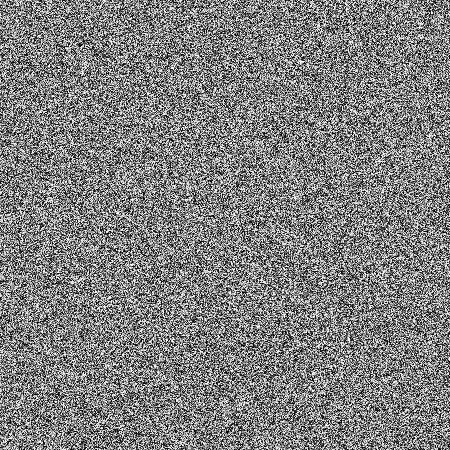

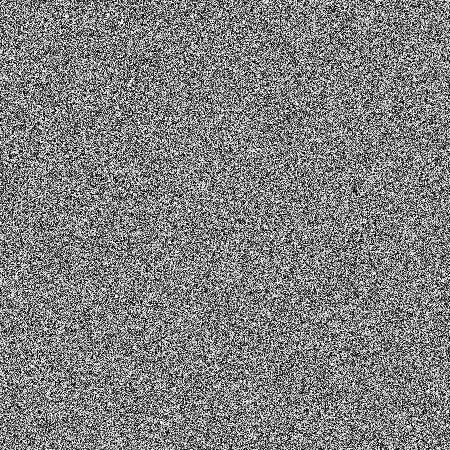

CPU times: user 11.1 s, sys: 31.2 ms, total: 11.2 s
Wall time: 11.3 s


In [3]:
%%time
#Read in the image and make it grayscale
im1=im.open('flower_on_lake.jpg')
im2=im.open('windmill.jpg')
org1=im1.convert('L')
org2=im2.convert('L')
og1=np.array(org1)
og2=np.array(org2)
height1=og1.shape[0]
width1=og1.shape[1]
height2=og2.shape[0]
width2=og2.shape[1]

#Generate secret key for the difussion step: initial condition of the logistic map
sign1=signature(og1)
sign2=signature(og2)
h1=hsh.sha512(sign1.encode("utf8"))
h2=hsh.sha512(sign2.encode("utf8"))
hash1=h1.hexdigest()
hash2=h2.hexdigest()
num1=int(hash1,16)
num2=int(hash2,16)
init1=1.0/num1
init2=1.0/num2
for i in range(500): #do a few iterations so the first operands in the xorop function aren't similar
    init1=3.999*init1*(1-init1)
    init2=3.999*init2*(1-init2)
print ('Initial condition flower:',init1)
print ('Initial condition windmill:',init2)

#Diffusion with logistic map
#Generate the operands for xor with each pixel with values between o and 255 (values of grayscale)
r=3.9999
xorop1=xorop(init1,r,height1*width1,256)
xorop2=xorop(init2,r,height2*width2,256)
#Change pixel values using the operands and XOR
enc1=np.copy(og1)
enc2=np.copy(og2)
enc1=xor(enc1,xorop1)
enc2=xor(enc2,xorop2)

#Confusion with arnolds cat map
iterations=50
p=2
q=1
for i in range(iterations):
    enc1=arn_enc(enc1,p,q)
    enc2=arn_enc(enc2,p,q)

#Generate encrypted image
encrypted_flower=im.fromarray(enc1)
encrypted_windmill=im.fromarray(enc2)
encrypted_flower.show()
encrypted_windmill.show()
#Save encrypted image
#encrypted_flower.save('encrypted_flower_xor',format='jpeg')
#encrypted_windmill.save('encrypted_windmill_xor',format='jpeg')

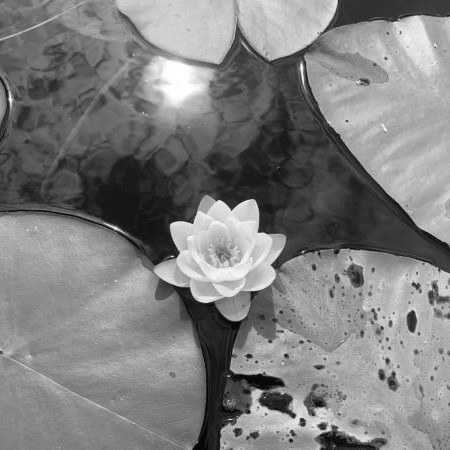

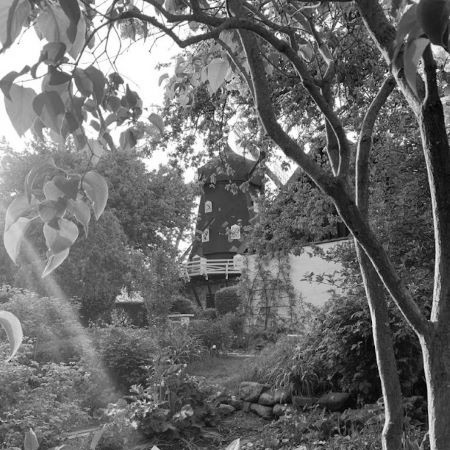

CPU times: user 12.7 s, sys: 15.6 ms, total: 12.7 s
Wall time: 12.8 s


In [4]:
%%time
#Decryption
#Unconfusion with inverse arnolds cat map
files=[]
iterations=50
p=2
q=1
dec1=np.copy(enc1)
dec2=np.copy(enc2)
for i in range(iterations):
    dec1=arn_dec(dec1,p,q)
    dec2=arn_dec(dec2,p,q)
#Retrieve pixel values with the operands and XOR
dec1=xor(dec1,xorop1)
dec2=xor(dec2,xorop2)
#Generate image decrypted image
decrypted_flower=im.fromarray(dec1)
decrypted_windmill=im.fromarray(dec2)
decrypted_flower.show()
decrypted_windmill.show()
#Save decrypted image
#decrypted_flower.save('decrypted_flower_xor_arnolds',format='jpeg')
#decrypted_windmill.save('decrypted_windmill_xor_arnolds',format='jpeg')

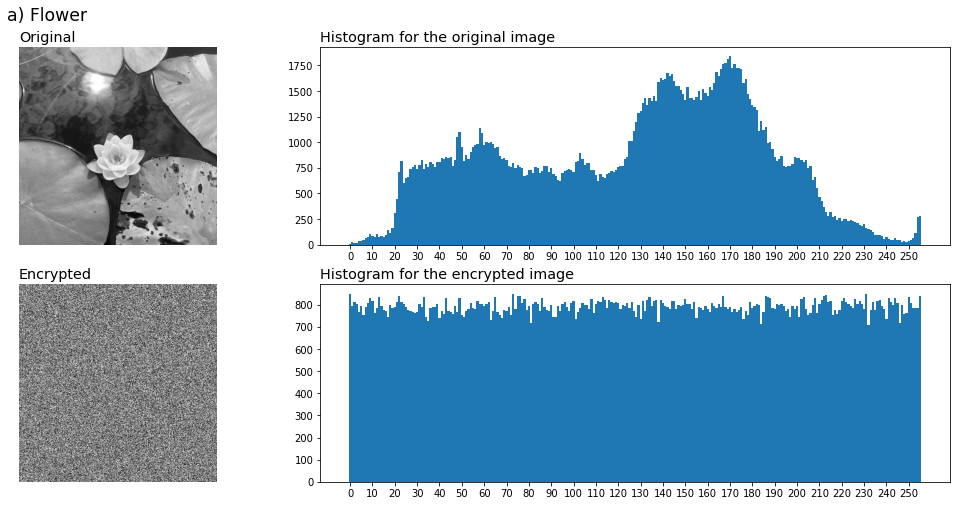

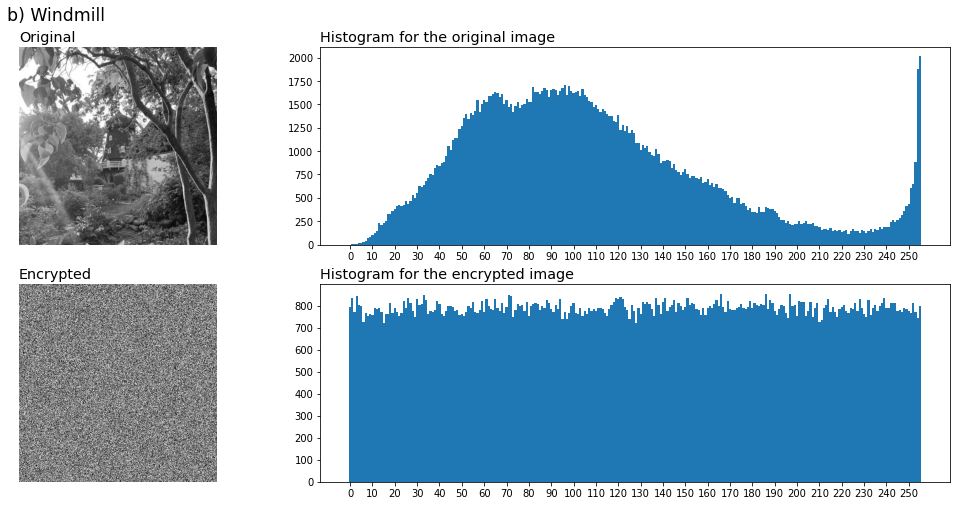

Flower
Original image entropy: 7.67
Encrypted image entropy: 8.0

Windmill
Original image entropy: 7.61
Encrypted image entropy: 8.0

Randomness limit: 8.0


In [5]:
#Randomness parameters: Histogram and entropy based randomness
nog1,probog1=num_and_prob(og1)
nog2,probog2=num_and_prob(og2)
nenc1,probenc1=num_and_prob(enc1)
nenc2,probenc2=num_and_prob(enc2)
#Make histograms
#Flower
pvals=range(256)
xticks=[i*10 for i in range(256//10+1)]
fig1,ax1=plt.subplots(2,2, figsize=(17,8),gridspec_kw={'width_ratios': [1, 2.7]})
ax1[0][0].imshow(org1,cmap='gray', vmin=0, vmax=255)
ax1[0][0].axis('off')
ax1[0][0].set_title("Original",loc='left',fontsize='x-large')
ax1[0][1].bar(pvals,nog1,width=1.0)
ax1[0][1].set_xticks(xticks)
ax1[0][1].set_xticklabels(xticks)
ax1[0][1].set_title("Histogram for the original image",loc='left',fontsize='x-large')
ax1[1][0].imshow(enc1,cmap='gray', vmin=0, vmax=255)
ax1[1][0].axis('off')
ax1[1][0].set_title("Encrypted",loc='left',fontsize='x-large')
ax1[1][1].bar(pvals,nenc1,width=1.0)
ax1[1][1].set_xticks(xticks)
ax1[1][1].set_xticklabels(xticks)
ax1[1][1].set_title("Histogram for the encrypted image",loc='left',fontsize='x-large')
fig1.suptitle("a) Flower", fontsize='xx-large',ha='left',x=0.13,y=0.95)
plt.show()
#Windmill
xticks=[i*10 for i in range(256//10+1)]
fig2,ax2=plt.subplots(2,2, figsize=(17,8),gridspec_kw={'width_ratios': [1, 2.7]})
ax2[0][0].imshow(org2,cmap='gray', vmin=0, vmax=255)
ax2[0][0].axis('off')
ax2[0][0].set_title("Original",loc='left',fontsize='x-large')
ax2[0][1].bar(pvals,nog2,width=1.0)
ax2[0][1].set_xticks(xticks)
ax2[0][1].set_xticklabels(xticks)
ax2[0][1].set_title("Histogram for the original image",loc='left',fontsize='x-large')
ax2[1][0].imshow(enc2,cmap='gray', vmin=0, vmax=255)
ax2[1][0].axis('off')
ax2[1][0].set_title("Encrypted",loc='left',fontsize='x-large')
ax2[1][1].bar(pvals,nenc2,width=1.0)
ax2[1][1].set_xticks(xticks)
ax2[1][1].set_xticklabels(xticks)
ax2[1][1].set_title("Histogram for the encrypted image",loc='left',fontsize='x-large')
fig2.suptitle("b) Windmill",fontsize='xx-large',ha='left',x=0.13,y=0.95)
plt.show()
#Entropy test
hog1=0
hog2=0
henc1=0
henc2=0
for i in range(256):
    if(probog1[i]!=0):
        hog1=hog1-probog1[i]*np.log2(probog1[i])
    if(probenc1[i]!=0):
        henc1=henc1-probenc1[i]*np.log2(probenc1[i])
    if(probog2[i]!=0):
        hog2=hog2-probog2[i]*np.log2(probog2[i])
    if(probenc2[i]!=0):
        henc2=henc2-probenc2[i]*np.log2(probenc2[i])
lim=np.log2(256)
print('Flower')
print('Original image entropy:', round(hog1,2))
print('Encrypted image entropy:', round(henc1,2))
print()
print('Windmill')
print('Original image entropy:', round(hog2,2))
print('Encrypted image entropy:', round(henc2,2))
print('')
print('Randomness limit:', lim)

In [6]:
#Fidelity parameters: Mean Square Error (MSE) and Peak Signal to Noice Ratio (PSNR)
moe1=mse(og1,enc1) 
mod1=mse(og1,dec1)
moe2=mse(og2,enc2)
mod2=mse(og2,dec2)
print("Flower MSE:")
print("Original vs encrypted: ",round(moe1,2))
print("Original vs decrypted: ",round(mod1,2))
print()
print("Windmill MSE:")
print("Original vs encrypted: ",round(moe2,2))
print("Original vs decrypted: ",round(mod2,2))
print()
poe1=psnr(og1,enc1) 
pod1=psnr(og1,dec1)
poe2=psnr(og2,enc2)
pod2=psnr(og2,dec2)
print("Flower PSNR:")
print("Original vs encrypted: ",round(poe1,2))
print("Original vs decrypted: ",pod1)
print()
print("Windmill PSNR:")
print("Original vs encrypted: ",round(poe2,2))
print("Original vs decrypted: ",pod2)

Flower MSE:
Original vs encrypted:  8542.96
Original vs decrypted:  0.0

Windmill MSE:
Original vs encrypted:  8886.78
Original vs decrypted:  0.0

Flower PSNR:
Original vs encrypted:  8.81
Original vs decrypted:  inf

Windmill PSNR:
Original vs encrypted:  8.64
Original vs decrypted:  inf


In [7]:
#Robustness parameters: Unified Average Changing Intensity (UACI), Number of Pixel Change Rate (NPCR) 
#Generate comparative cypher by changing one pixel value of original
test1=np.copy(og1)
test2=np.copy(og2)
test1[height1//2][width1//2]=(og1[height1//2][width1//2]+12345)%256
test2[height2//2][width2//2]=(og2[height2//2][width2//2]+12345)%256
signt1=signature(test1)
signt2=signature(test2)
ht1=hsh.sha512(signt1.encode("utf8"))
ht2=hsh.sha512(signt2.encode("utf8"))
hasht1=ht1.hexdigest()
hasht2=ht2.hexdigest()
numt1=int(hasht1,16)
numt2=int(hasht2,16)
initt1=1.0/numt1
initt2=1.0/numt2
for i in range(500): #do a few iterations so the first operands in the xorop function aren't similar
    initt1=3.999*initt1*(1-initt1)
    initt2=3.999*initt2*(1-initt2)
#Change pixel values using the operands and XOR
r=3.9999
tenc1=np.copy(test1)
tenc2=np.copy(test2)
xoropt1=xorop(initt1,r,height1*width1,256)
xoropt2=xorop(initt2,r,height1*width1,256)
tenc1=xor(tenc1,xoropt1)
tenc2=xor(tenc2,xoropt2)
#Then confusion with arnolds cat map
iterations=50
p=2
q=1
for i in range(iterations):
    tenc1=arn_enc(tenc1,p,q)
    tenc2=arn_enc(tenc2,p,q)
u1=uaci(enc1,tenc1)
n1=npcr(enc1,tenc1)
u2=uaci(enc2,tenc2)
n2=npcr(enc2,tenc2)
print("Flower:")
print("UACI: ",round(u1,2),"%")
print("NPCR: ",round(n1,2),"%")
print()
print("Windmill:")
print("UACI: ",round(u2,2),"%")
print("NPCR: ",round(n2,2),"%") 

Flower:
UACI:  33.35 %
NPCR:  99.6 %

Windmill:
UACI:  33.47 %
NPCR:  99.58 %
